In [1683]:
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
%matplotlib inline

In [1684]:
import warnings
warnings.filterwarnings('ignore')

In [1685]:
data = h5py.File('data/Q1/MNIST_Subset.h5','r+')
X=data['X'][:]
Y=data['Y'][:]

In [1686]:
X.shape,Y.shape

((14251, 28, 28), (14251,))

In [1687]:
X = X.reshape(X.shape[0],-1)

In [1688]:
X=X/255

In [1689]:
np.unique(Y)

array([7, 9], dtype=uint8)

In [1690]:
#as we only have 2 classes
Y = np.where(Y==7,0,1)

In [1691]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

In [1692]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((11400, 784), (2851, 784), (11400,), (2851,))

In [1693]:
def one_hot_encoding(Y):
    n_classes = len(np.unique(Y))
    Y=Y.reshape(1,Y.shape[0])
    Y_new = np.eye(n_classes)[Y.astype('int32')]
    Y_new = Y_new.T.reshape(n_classes, Y.shape[1])
    return Y_new,n_classes

In [1694]:
Y_train,n_classes = one_hot_encoding(Y_train)
Y_test,n_classes=one_hot_encoding(Y_test)

In [1695]:
Y_train.shape,Y_test.shape

((2, 11400), (2, 2851))

In [1696]:
X_train=X_train.T
X_test=X_test.T

In [1697]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((784, 11400), (784, 2851), (2, 11400), (2, 2851))

In [1698]:
def relu(z,derative = False):
    if derative:
        z[z<=0]=0
        z[z>0]=1
        return z
    z[z<0]=0
    return z

In [1699]:
def sigmoid(z,derative = False):
    if derative:
        print("===================input to sigmoid derv====================")
        print(z)
        print("================output of sig derv=============")
        temp = sigmoid(z)*(1-sigmoid(z))
        print(temp)
#         return z*(1-z)
        return temp
    return 1.0/(1.0+np.exp(-z))

In [1700]:
def softmax(z):
    z=z-np.max(z,axis=0)
    return np.exp(z)/np.sum(np.exp(z),axis=0)

In [1701]:
def compute_multiclass_loss(Y, Y_hat):
    print("&&&&&&&&&&&&&INSIDe cost function%%%%%%%%%%")
    print("===========true labels===================")
    print(Y)
    print("===========predic labels===================")
    print(Y_hat)
    print("========fixing predicted loss=========")
    Y_hat[Y_hat==0.] = 0.0001
    Y_hat[Y_hat==1.] = 0.9999
    print(Y_hat)
    print("============log of lablesl=============")
    print(np.log(Y_hat))
    print("=================multiple=============")
    print(np.multiply(Y, np.log(Y_hat)))
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    return -(1/m) * L_sum

In [1702]:
def get_class_values(results):
    return results.argmax(axis=0)

In [1703]:
def init_weights(n_hidden_layers, number_of_neurons):
    weights_layers =[np.random.uniform(size=(number_of_neurons[0],X_train.shape[0]))]
    bias_layers = [np.random.uniform(size=(number_of_neurons[0],1))]
    
    for i in range(1,n_hidden_layers):
        weights_layers.append(np.random.uniform(size=(number_of_neurons[i],weights_layers[i-1].shape[0])))
        bias_layers.append(np.random.uniform(size=(number_of_neurons[i],1)))
    
    weights_layers.append(np.random.uniform(size=(n_classes,weights_layers[-1].shape[0])))
    bias_layers.append(np.random.uniform(size=(n_classes,1)))
    
    return weights_layers,bias_layers

In [1704]:
def train_neural_network(X_train,Y_train,epoch,learning_rate,hidden_layer_activation):
    global weight_layers
    global bias_layers
    
    cost=[]
    number_of_samples = X_train.shape[1]

    
    #------epoch start here----------
    while epoch>0:
        print("################EPOCH start here ############")
        input_layers = [X_train]
        output_layers=[X_train]

        delta_weights = []
        delta_bias = []


        for weight,bias in zip(weight_layers[:-1],bias_layers[:-1]):
            print("%%%%%%%%%%%%%Hidden layer%%%%%%%%%%%%%%")
            print("=========A in W.A+B=============")
            print(output_layers[-1])
            print("=========W in W.A+B=============")
            print(weight)
            print("=========B in W.A+B=============")
            print(bias)
            input_layers.append(np.dot(weight,output_layers[-1])+bias)
            print('==============input to the layer==============')
            print(input_layers[-1])
            output_layers.append(hidden_layer_activation(input_layers[-1]))
            print("============output after activation===========")
            print(output_layers[-1])

        print('%%%%%%%%%%%%%%%%output layer%%%%%%%%%%%%%')
        print("=========A in W.A+B=============")
        print(output_layers[-1])
        print("=========W in W.A+B=============")
        print(weight_layers[-1])
        print("=========B in W.A+B=============")
        print(bias_layers[-1])
        input_layers.append(np.dot(weight_layers[-1],output_layers[-1])+bias_layers[-1])
        print('==============input to the layer==============')
        print(input_layers[-1])
        output_layers.append(softmax(input_layers[-1]))
        print("============output after activation===========")
        print(output_layers[-1])
        
        
        c=compute_multiclass_loss(Y_train,output_layers[-1])
        print(f"cost = {c}")
        if np.isnan(c):
            print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
        cost.append(c)
        

        #------Output layer error --------
        error = output_layers[-1] - Y_train
        print("================output layer error==========")
        print(error)
        
        
        delta_weights.append((1./number_of_samples)*np.dot(error,output_layers[-2].T))
        print("=====delta weight output layer============")
        print(delta_weights[0])
        
        delta_bias.append((1./number_of_samples)*np.sum(error, axis=1, keepdims=True))
        print("=====delta bias output layer============")
        print(delta_bias[0])
        
        #-----hidden layer stuff

        for i in range(len(input_layers)-1)[:0:-1]:
            error = np.dot(weight_layers[i].T,error)
            print("==============error this layer========")
            print(error)
            delta_z = error*hidden_layer_activation(input_layers[i],derative=True)
            print("==========input layer derv==========")
            print(hidden_layer_activation(input_layers[i],derative=True))
            print("=======delta z===========")
            print(delta_z)
            delta_weights.insert(0,(1./number_of_samples)*np.dot(delta_z,output_layers[i-1].T))
            print("=====delta weight layer============")
            print(delta_weights[0])
            delta_bias.insert(0,(1./number_of_samples)*np.sum(error,axis=1,keepdims=True))
            print("=====delta bias layer============")
            print(delta_bias[0])

        for i in range(len(weight_layers)):
#             delta_weights[i][np.isnan(delta_weights[i])] = 0.0
            weight_layers[i]=weight_layers[i]-learning_rate*delta_weights[i]
            bias_layers[i]=bias_layers[i]-learning_rate*delta_bias[i]
        if np.isnan(c):
            assert(False)
        epoch-=1

    return cost

In [1713]:
#hyperparameters
epoch = 20
learning_rate = 0.01

In [1728]:
%%capture
weight_layers,bias_layers = init_weights(3,[100,50,50])
hidden_layer_activation = sigmoid
cost = train_neural_network(X_train,Y_train,epoch,learning_rate,hidden_layer_activation=hidden_layer_activation)
# cost = train_neural_network(X_train,Y_train,epoch,learning_rate)

In [1729]:
# cost#

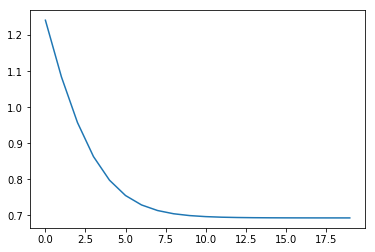

In [1730]:
plt.plot(range(len(cost)),cost)

In [1731]:
def predict(X_test,hidden_layer_activation):
    global weight_layers
    global bias_layers
    

    input_layers = [X_test]
    output_layers=[X_test]

    for weight,bias in zip(weight_layers[:-1],bias_layers[:-1]):
        input_layers.append(np.dot(weight,output_layers[-1])+bias)
        output_layers.append(hidden_layer_activation(input_layers[-1]))

    input_layers.append(np.dot(weight_layers[-1],output_layers[-1])+bias_layers[-1])
    output_layers.append(softmax(input_layers[-1]))
    return get_class_values(output_layers[-1])

In [1732]:
def get_performance(x,y):
    results = predict(x,hidden_layer_activation=hidden_layer_activation)
    y=get_class_values(y)
    acc = accuracy_score(y,results)
    print(f"Accuracy score = {acc}")
    cnf = confusion_matrix(y,results)
    print(cnf)
    df_cm = pd.DataFrame(cnf, index = range(2),columns = range(2))
    sn.heatmap(df_cm, annot=True)
    return acc

Accuracy score = 0.512101017186952
[[1460    0]
 [1391    0]]


0.512101017186952

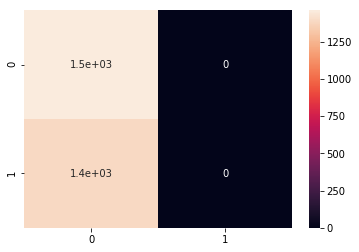

In [1733]:
get_performance(X_test,Y_test)

Accuracy score = 0.5116666666666667
[[5833    0]
 [5567    0]]


0.5116666666666667

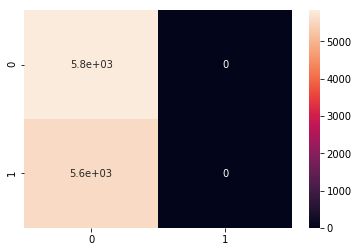

In [1734]:
get_performance(X_train,Y_train)